# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy and cosmology the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight alterations to the path of massless particles like light - and also particles with mass - in the vicinity of black holes. We start with the Schwarzschild metric which describes particle motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

The following code explores General Relativity via the Schwarzschild metric. The next steps will be to add the proposed quantum corrections to see how this alters the path of light and thus, our understanding of black holes.

In [1]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import sympy as sp
import OGRePy as gr
from OGRePy.abc import t, r, theta, phi, E, M, L, lamda, sigma, epsilon
from IPython.display import display, Math

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.3.0 (2025-02-04)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

**OGRePy**: You have the latest version of the package.

In [2]:
# Define symbolic variables
t = gr.sym('t')
r = gr.sym('r', nonnegative=True)
theta = gr.sym('theta')
phi = gr.sym('phi')
lamda = gr.sym('lamda')
sigma = gr.sym('sigma')
epsilon = gr.sym('epsilon')
E = gr.sym('E')
M = gr.sym('M')
L = gr.sym('L')
Q_b = gr.sym('Q_b')
Q_c = gr.sym('Q_c')
v_eff = gr.sym('v_eff')
r_sc = gr.sym('r_sc')

# symbol test
diff_expr = gr.s.diff(Q_b**2 + Q_c, Q_b)
display(Math(sp.latex(diff_expr)))


<IPython.core.display.Math object>

# Schwarzschild Metric Tensor

The Schwarzschild metric is a 3 x 3 matrix. In order to visualize it we've rendered it using symbols.

In [3]:
# Block 1 - display metric tensor - use OGRePy

def build_metric():
    # define symbolic variables for t, r, theta, phi
    spher_coords = gr.Coordinates(t, r, theta, phi)
    
    # define metric functions symbolically
    f = gr.func('f')('r')
    g = gr.func('g')('r')
    h = gr.func('h')('r')

    the_metric = gr.Metric(coords=spher_coords, components=gr.diag(-f, g, h, h * gr.s.sin(theta)**2))

    return the_metric, spher_coords

# build the symbolic metric
metric_sym, coords1 = build_metric()

metric_sym.show()
coords1.show()


$$g{}_{\mu}{}_{\nu}\Bigg|_{\left(t, r, \theta, \phi\right)} = \left(\begin{matrix}- f{\left(r \right)} & 0 & 0 & 0\\0 & g{\left(r \right)} & 0 & 0\\0 & 0 & h{\left(r \right)} & 0\\0 & 0 & 0 & h{\left(r \right)} \sin^{2}{\left(\theta \right)}\end{matrix}\right)$$

$$\left(\begin{matrix}t & r & \theta & \phi\end{matrix}\right)$$

# Schwarzschild functions

The following code block is for functions that derive from the Schwarzschild metric representing a static, spherically symmetric spacetime:  

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$
                                                      
If we put this in the form of a point particle Lagrangian we get:  

$$ \mathcal{L} = - f(r) \, \dot{t}^2 + g(r) \, \dot{r}^2 + h(r) \left( \dot{\theta}^2 + \sin^2\theta \, \dot{\phi}^2 \right) $$

Due to spherical symmetry we can confine calculations to the equatorial plane where, $\theta = \frac{\pi}{2}$ and, $\sin^2(\theta) = 1$. Then if we integrate once we get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the schwarzschild metric functions, the conserved quantities, E (energy) and L (angular momentum) and $\sigma$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = - f(r) \left( \sigma - \frac{L^2}{h(r)} \right)$$

an expression that is comparable to gravitational potential energy in Newtonian mechanics. Below we define the Schwarzschild metric functions, Effective Potential, and Equations of Motion for a Schwarzschild spacetime. 

$$V_{\text{eff}}(r) = - \frac{1}{2} f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

In [3]:
# block 2 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# constants: normalized speed of light & gravitational constant
c = 1.0 
G = 1.0 

# get schwarzschild radius from mass
def r_sc(M):
    return (2*G*M/c**2)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return -(1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return -0.5*f(r, M, Q_b, Q_c) * (L**2*h(r, M, Q_c)**(-1) + epsilon)

# lamda - not accessed in this function - can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    dr_dlamda = gr.s.sqrt(g(r, M, Q_b, Q_c)**(-1) * (f(r, M, Q_b, Q_c)**(-1) * E**2 + (epsilon - L**2 / h(r, M, Q_c))))

    return [dt_dlamda, dr_dlamda, dphi_dlamda]

# symbols test
display(Math(r"v_{eff} (\epsilon = 0) = " + sp.latex(v_eff(r, M, L, Q_b, Q_c))))

<IPython.core.display.Math object>

# Assign Values to Constants

Here we assign values for Mass (central massive object), and Energy and Angular momentum of the orbiting particle. Print out the metric components with these assigned values.

In [34]:
# block 3 - assign values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75

# conserved quantities (constants)
E1 = 1.1 # energy of orbiting particle
L1 = 4.0 # angular momentum of orbiting particle

# calculate and print SC metric components for the given radial distance from the BH and mass of the BH.
f1 = f(r1, M1, Q_b1, Q_c1)
g1 = g(r1, M1, Q_b1, Q_c1)
h1 = h(r1, M1, Q_c1)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = -0.900593754879089
g(r) = 1.11107255028028
h(r) = 400.00000000097657


# Effective Potential as a function of radius from the black hole

Next we explore the effective potential function. We find that there is a maxima outside the Schwarzschild radius. To have orbits (around a massive object) we need either a maxima or a minima. Minima produce very stable orbits. Maxima can sustain an orbit but the object is easily knocked out of this orbit. If we plot $V_{\text{eff}}(r)$ and change the values of L we find that the extremum (maximum) is always at the same value of r.

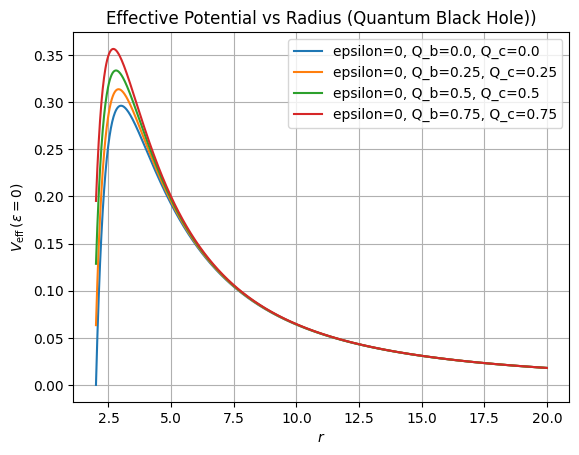

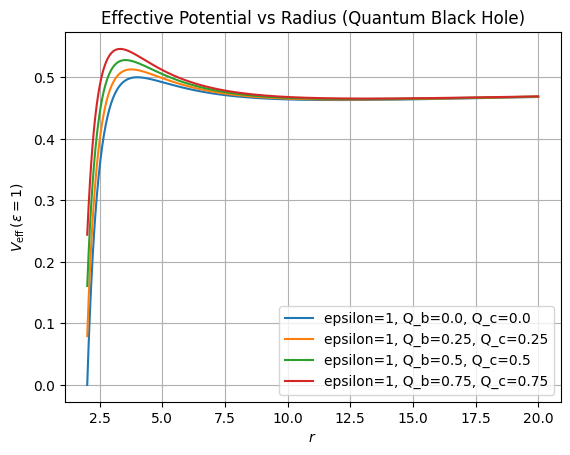

In [35]:
# block 4 - calculate v_eff as a function of r given M (black hole mass), L (particles's angular momentum)
# span of r values
r_vals = np.linspace(rs1, r1, 1000)

# get list of effective potential values for sigma=0
v_eff_vals_Q0 = np.array([v_eff(i, M1, L1, Q_b0, Q_c0, epsilon=0) for i in r_vals])
v_eff_vals_Q1 = np.array([v_eff(i, M1, L1, Q_b1, Q_c1, epsilon=0) for i in r_vals])
v_eff_vals_Q2 = np.array([v_eff(i, M1, L1, Q_b2, Q_c2, epsilon=0) for i in r_vals])
v_eff_vals_Q3 = np.array([v_eff(i, M1, L1, Q_b3, Q_c3, epsilon=0) for i in r_vals])

# get list of effective potential values for sigma=1
v_eff_vals_Q0_1 = np.array([v_eff(i, M1, L1, Q_b0, Q_c0, epsilon=1) for i in r_vals])
v_eff_vals_Q1_1 = np.array([v_eff(i, M1, L1, Q_b1, Q_c1, epsilon=1) for i in r_vals])
v_eff_vals_Q2_1 = np.array([v_eff(i, M1, L1, Q_b2, Q_c2, epsilon=1) for i in r_vals])
v_eff_vals_Q3_1 = np.array([v_eff(i, M1, L1, Q_b3, Q_c3, epsilon=1) for i in r_vals])

# Plot the results epsilon = 0
plt.plot(r_vals, v_eff_vals_Q0, label=f'epsilon=0, Q_b={Q_b0}, Q_c={Q_c0}')
plt.plot(r_vals, v_eff_vals_Q1, label=f'epsilon=0, Q_b={Q_b1}, Q_c={Q_c1}')
plt.plot(r_vals, v_eff_vals_Q2, label=f'epsilon=0, Q_b={Q_b2}, Q_c={Q_c2}')
plt.plot(r_vals, v_eff_vals_Q3, label=f'epsilon=0, Q_b={Q_b3}, Q_c={Q_c3}')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 0)$')
plt.title('Effective Potential vs Radius (Quantum Black Hole))')
plt.legend()
plt.grid(True)
plt.show()
# Plot the results epsilon = 1
plt.plot(r_vals, v_eff_vals_Q0_1, label=f'epsilon=1, Q_b={Q_b0}, Q_c={Q_c0}')
plt.plot(r_vals, v_eff_vals_Q1_1, label=f'epsilon=1, Q_b={Q_b1}, Q_c={Q_c1}')
plt.plot(r_vals, v_eff_vals_Q2_1, label=f'epsilon=1, Q_b={Q_b2}, Q_c={Q_c2}')
plt.plot(r_vals, v_eff_vals_Q3_1, label=f'epsilon=1, Q_b={Q_b3}, Q_c={Q_c3}')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 1)$')
plt.title('Effective Potential vs Radius (Quantum Black Hole)')
plt.legend()
plt.grid(True)
plt.show()


# Extrema and Limits

In the following code block When we take the derivative of $V_{\text{eff}}(r)$ and set it equal to zero, we are solving for the critical points (or roots) of the first derivative. These critical points are where the slope of the effective potential is zero, which corresponds to potential extrema (maxima or minima). To determine whether these critical points are maxima or minima, we take the second derivative $\frac{d^2V_{\text{eff}}}{dr^2}$. If the second derivative is negative at a particular critical point, it indicates a maximum, while a positive value suggests a minimum.

In the case of a massless particle ($\sigma = 0$) there is a maximum at r = 3 * M.

Next we locate extrema numerically using 'scipy.signal', a function used in signal processing and find the extrema to be located at the same spot.

What follows is an observation for $v_{\text{eff}}(r)$ as $r \to \infty$:

Null Geodesics ($\sigma = 0$)
As $r \to \infty$
$v_{\text{eff}} \to -(1 - 0) \cdot (0 - 0) = 0$
i.e. approaches 0 asymptotically

Time-like Geodesics ($\sigma = 1$)
As $r \to \infty$
$v_{\text{eff}} \to -(1 - 0) \cdot (1 - 0) = -1$ 
i.e. approaches -1 asymptotically


Extrema for ε = 0:
r = 2.9013, v_eff = 0.3138, Type: max

Extrema for ε = 1:
r = 3.7583, v_eff = 0.5128, Type: max
r = 12.3936, v_eff = 0.4638, Type: min


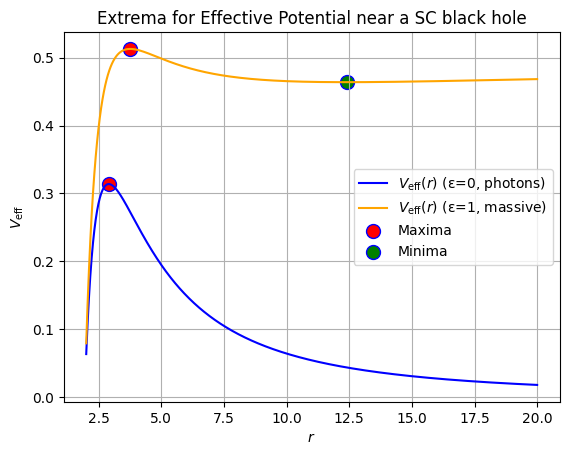

In [ ]:
# Block 5 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema_num(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = -0.5 * f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # v_eff value at extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff

r_range = (rs1, 10 * rs1)
eps0 = 0
eps1 = 1

# locate extrema for massless particles (epsilon = 0)
ext_photons, v_eff_photons = find_extrema_num(M1, L1, Q_b1, Q_c1, eps0, r_range)

# locate extrema for massive particles (epsilon = 1)
ext_timelike, v_eff_timelike = find_extrema_num(M1, L1, Q_b1, Q_c1, eps1, r_range)

r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
v_eff_vals_photons = [v_eff_photons.subs(r, rv) for rv in r_vals1]
v_eff_vals_timelike = [v_eff_timelike.subs(r, rv) for rv in r_vals1]

# separate maxima, minima
max_x, max_y = [], []
min_x, min_y = [], []

for r_ex, v_eff_at_r, ext_type in ext_photons + ext_timelike:
    if ext_type == "max":
        max_x.append(r_ex)
        max_y.append(v_eff_at_r)
    else:
        min_x.append(r_ex)
        min_y.append(v_eff_at_r)

plt.plot(r_vals1, v_eff_vals_photons, color='b', label=r'$V_{\mathrm{eff}}(r)$ (ε=0, photons)')
plt.plot(r_vals1, v_eff_vals_timelike, color='orange', label=r'$V_{\mathrm{eff}}(r)$ (ε=1, massive)')
plt.scatter(max_x, max_y, color='r', s=100, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=100, edgecolors='b', label="Minima")
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title("Extrema for Effective Potential near a SC black hole")
plt.legend()
plt.grid(True)
plt.show()

Extrema for epsilon=0:
r = 2.9009, V_eff = 0.3138

Extrema for epsilon=1:
r = 3.7658, V_eff = 0.5128
r = 12.3964, V_eff = 0.4638


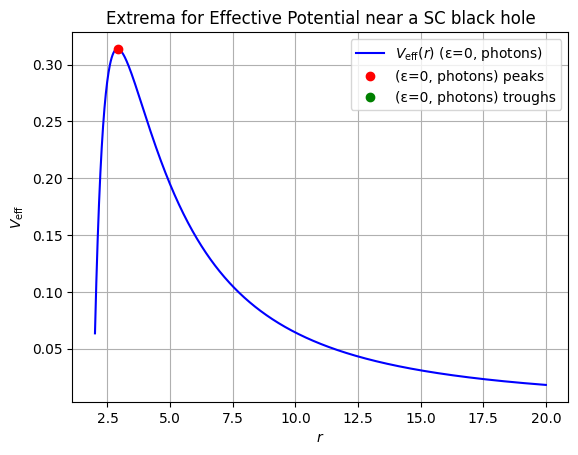

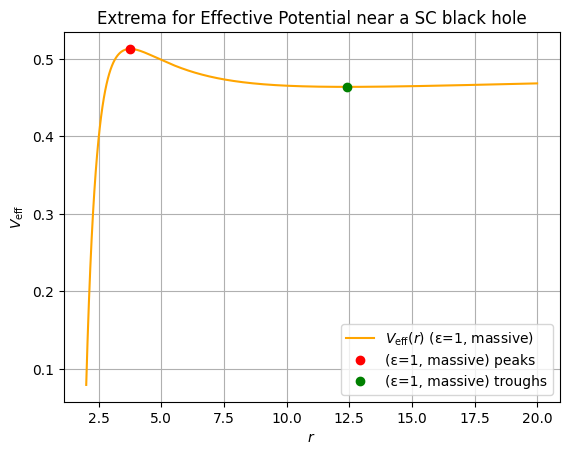

In [51]:
# block 6 - find extrema for v_eff vs r for the space around a black hole in a quantum-corrected Schwarzschild metric.
# solved numerically using scipy "find_peaks"...borrowed from signal processing.

from scipy.signal import find_peaks

# find peaks for sigma=0, sigma=1
peaks1, _ = find_peaks(v_eff_vals_Q1)
peaks2, _ = find_peaks(v_eff_vals_Q1_1)

# detect troughs (invert the function to find minima as peaks) for epsilon=0, epsilon=1
troughs1, _ = find_peaks(-v_eff_vals_Q1)
troughs2, _ = find_peaks(-v_eff_vals_Q1_1)

# combine and sort extrema
extrema1 = np.sort(np.concatenate((peaks1, troughs1)))
extrema2 = np.sort(np.concatenate((peaks2, troughs2)))

# print extrema values for epsilon=0 and epsilon=1
print("Extrema for epsilon=0:")
for j in extrema1:
    print(f"r = {r_vals[j]:.4f}, V_eff = {v_eff_vals_Q1[j]:.4f}")

print("\nExtrema for epsilon=1:")
for k in extrema2:
    print(f"r = {r_vals[k]:.4f}, V_eff = {v_eff_vals_Q1_1[k]:.4f}")

plt.plot(r_vals, v_eff_vals_Q1, color='b', label=r'$V_{\mathrm{eff}}(r)$ (ε=0, photons)')
plt.plot(r_vals[peaks1], v_eff_vals_Q1[peaks1], 'o', color='r', label='(ε=0, photons) peaks')
plt.plot(r_vals[troughs1], v_eff_vals_Q1[troughs1], 'o', color='g', label='(ε=0, photons) troughs')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Extrema for Effective Potential near a SC black hole')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(r_vals, v_eff_vals_Q1_1, color='orange', label=r'$V_{\mathrm{eff}}(r)$ (ε=1, massive)')
plt.plot(r_vals[peaks2], v_eff_vals_Q1_1[peaks2], 'o', color='r', label='(ε=1, massive) peaks')
plt.plot(r_vals[troughs2], v_eff_vals_Q1_1[troughs2], 'o', color='g', label='(ε=1, massive) troughs')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Extrema for Effective Potential near a SC black hole')
plt.legend()
plt.grid(True)
plt.show()

# Orbits - method 1

In the first approach we find $r(\phi)$ using the following expression,

$$\frac{dr}{d\phi} = \frac{\dot{r}}{\dot{\phi}} = \frac{h(r)}{L} \sqrt{\frac{1}{g(r)} \left( \frac{E^2}{f(r)} + \left( \sigma - \frac{L^2}{h(r)} \right) \right)}$$

then integrate using 'solve_ivp' and plot in polar format. In the next code block we define a solver named 'solve_r_phi' then in the following code block we set initial conditions, run the solver, and plot the orbit.

In [58]:
# block 7 - solve for r(phi) and make a polar plot
# define dr/dphi solver function for integration
def solve_r_phi(params, phi_range, r_init, epsilon=0):
    """
    Solve for r as a function of phi using solve_ivp.
    
    Parameters:
    params : list
        [E, L, M] where E is energy, L is angular momentum, and M is mass.
    phi_range : tuple
        (phi_start, phi_end) range for integration.
    r_init : float
        Initial radial distance.
    sigma : int, optional
        Value for sigma (default is 0).
    
    Returns:
    sol : OdeSolution
        Solution object from solve_ivp.
    """
    E, L, M, Q_b, Q_c = params  # unpack parameters
    
    def dr_dphi(phi, y):
        r = y[0]
        corr = 1e-6
        
        # stop integration if r is out of bounds
        if r <= rs1 + corr or r >= r_max:
            return [0] 
        
        hh = h(r, M, Q_c)
        ff = f(r, M, Q_b, Q_c)
        gg = g(r, M, Q_b, Q_c)
        dr_dphi = (hh / L) * np.sqrt(max(0, 1 / gg * (E**2 / ff + (epsilon - L**2 / hh))))
        return [dr_dphi]
    
    # Solve the ODE
    sol = solve_ivp(dr_dphi, phi_range, [r_init], t_eval=np.linspace(*phi_range, 1000), atol=1e-5, rtol=1e-5)
    return sol

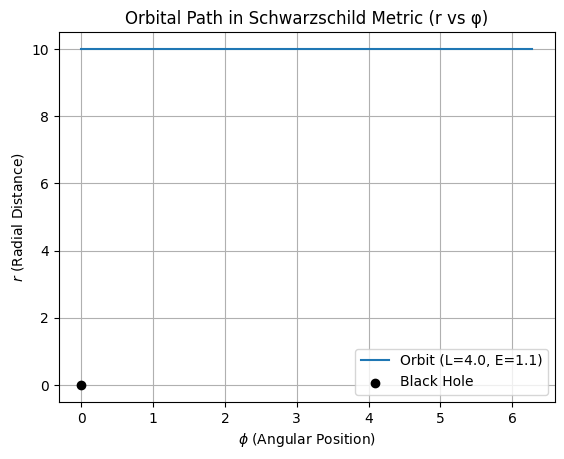

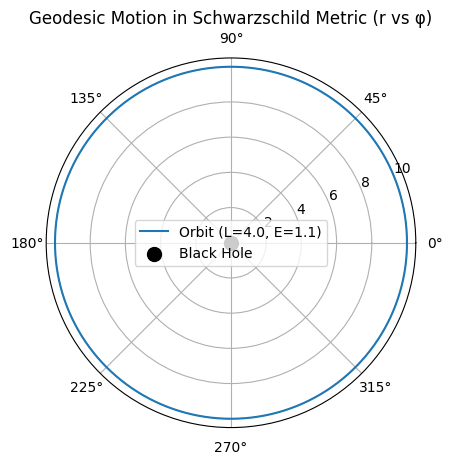

In [60]:
# Block 8
# code to integrate dr_dphi and display as a polar plot

# initial conditions
phi_range = (0, 2 * np.pi)
r_init = 5 * rs1 
params = [E1, L1, M1, Q_b1, Q_c1]
r_max = 10 * rs1
sol_r_phi = solve_r_phi(params, phi_range, r_init)

# extract solution
phi_vals = sol_r_phi.t
r_vals = sol_r_phi.y[0]
valid_indices = r_vals <= r_max
phi_vals2 = phi_vals[valid_indices]
r_vals2 = r_vals[valid_indices]

plt.plot(phi_vals2, r_vals2, label=f'Orbit (L={L1}, E={E1})')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlabel(r'$\phi$ (Angular Position)')
plt.ylabel(r'$r$ (Radial Distance)')
plt.title('Orbital Path in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()

# plar plot
plt.polar(phi_vals2, r_vals2, label=f'Orbit (L={L1}, E={E1})')
plt.scatter([0], [0], color='black', marker='o', s=100, label='Black Hole', zorder=5)
plt.title('Geodesic Motion in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()

# Orbits - method 2

In the 2nd approach we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the equations of motion $\frac{dr}{d\lambda}$ and $\frac{d\phi}{d\lambda}$ with 'solve_ivp' then we plot $r(\lambda)$ vs $\phi(\lambda)$ in parametric format.

In the following code block we define the solver function, 'solve_r_phi_tau', then in the following block we set initial conditions, run the solver, and plot.

In [61]:
# block 9 - solver to compute r(lambda), phi(lambda)

# solve for r and phi as a function of tau using eq_of_motion
def solve_r_phi_lamda(params, lamda_range, r_init, phi_init, epsilon=0):

    E, L, M, Q_b, Q_c = params

    # initial conditions [t, r, phi]
    y0 = [0, r_init, phi_init] 

    def dy_dt(lamda, y):
        # get ODE's from eq_of_motion function
        dt_dlamda, dr_dlamda, dphi_dlamda = eq_of_motion(lamda, y, params, epsilon)

        return [dt_dlamda, dr_dlamda, dphi_dlamda]

    # solve for r(lambda) and phi(lambda)
    sol = solve_ivp(dy_dt, lamda_range, y0, t_eval=np.linspace(*lamda_range, 1000), atol=1e-5, rtol=1e-5)
    return sol


In [62]:
# block 10 
# initial conditions / constants
r_init = 1.5 * rs1  
params = [E1, L1, M1, Q_b1, Q_c1]

lamda_range = [0, 10]
phi_init = 0

sol_y = solve_r_phi_lamda(params, lamda_range, r_init, phi_init, epsilon=0)

if not sol_y.success:
    print("Integration failed:", sol_y.message)

# get results for r(lamda) and phi(lamda)
r_vals2 = sol_y.y[1]  # radial distances
phi_vals2 = sol_y.y[2]  # angular positions

# parametric plot: r(lamda) vs phi(lamda)
plt.plot(phi_vals2, r_vals2, label=f'r vs φ')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlabel(r'$\phi$ (Angular Position)')
plt.ylabel(r'$r$ (Radial Distance)')
plt.title('Parametric Motion: r(lamda) vs φ(lamda)')
plt.legend()
plt.grid(True)
plt.show()

TypeError: Cannot convert complex to float